In [4]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18, z_at_value
from astropy.constants import c
from scipy.ndimage.filters import gaussian_filter
import astropy.units as u
import hankl
from scipy import interpolate
from scipy.integrate import quadrature
from scipy.special import jv
%matplotlib inline

/var/folders/l0/bsqsn6_s01b0hvjnf7bv_wdw0000gn/T/ipykernel_97910/2992060812.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Calculate $C_l^{\Delta \phi}(k_1,k_2)$

Text(0.5, 1.0, 'Fiducial')

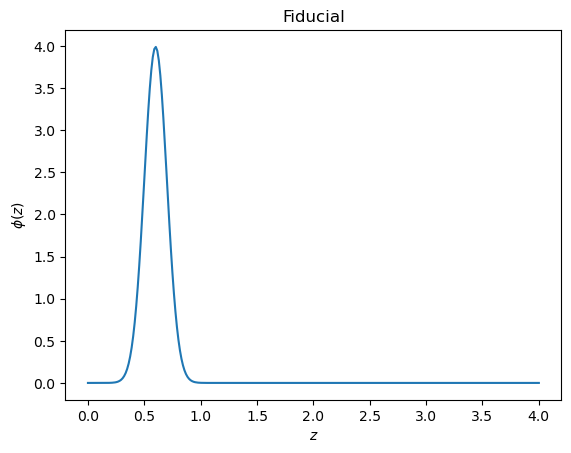

In [28]:
def phi(r, phi_normalization=None):
    '''
    Fiducial, radial galaxy selection function (i.e., the dn/dz)
    Inputs:
        - r = float. Comoving radial distance in Mpc
        - phi_normalization = Normalization of selection function. Default is unnormalized. 
    Returns:
        - phi(r)
    '''
    if phi_normalization is None:
        phi_normalization = 1
    z = z_at_value(Planck18.comoving_distance, r* u.Mpc).value
    return np.exp(-(z - z_mean)**2 /(2*sigma**2)) / phi_normalization

def phi_times_dzdr(r, phi_normalization=None):
    '''
    (dz/dr)(dn/dz)=(H(z)/c)(dn/dz) where dn/dz=phi(r)
    Inputs:
        - r = float. Comoving radial distance in Mpc
        - phi_normalization = Normalization of selection function. Default is unnormalized. 
    Returns:
        - (H(z)/c) phi(r)
    '''
    z_of_r = z_at_value(Planck18.comoving_distance, r* u.Mpc) 
    return (Planck18.H(z_of_r) / c).value * phi(r, phi_normalization)

sigma = 0.1 # Standard deviation of the fiducial dndz
z_mean = 0.6 # Central redshift of the fiducial dndz

# Set the range for the integrals over r. If this changes, the normalization of phi(r) will need to be changed too
z_min_int = 0.005
z_max_int = 5 #z_mean+2

# Normalize the selection function so that \int_{0}^{inf} dr phi(r) = 1
phi_norm, error = quadrature(phi_times_dzdr, Planck18.comoving_distance(z_min_int).value, 
                                       Planck18.comoving_distance(z_max_int).value,
                                             tol=1e-20, maxiter=500)

# Plot the fiducial dndz
zs = np.linspace(0,4,300)
dndz_fid = np.exp(-(zs - z_mean)**2 /(2*sigma**2)) / (sigma*np.sqrt(2*np.pi))
plt.plot(zs, dndz_fid)
plt.ylabel(r'$\phi(z)$')
plt.xlabel(r'$z$')
plt.title('Fiducial')

In [29]:
# Suppose the central value of the dndz changes across different healpixels
nside = 16 # Nside that sets the size of pixels over which dn/dz is constant
npix = hp.nside2npix(nside)

# Initialize samples in r to be used in FFTLog calculation of the Hankel transforms
n_samples_of_r = 2**10 # Choose a power of 2
log_rmin = -4 # Choose integers here
log_rmax = 4 # Choose integers here
r_array = np.logspace(log_rmin,log_rmax,n_samples_of_r) 
# Get the redshift corresponding to these values of r in the Planck18 cosmology
z_array = np.zeros((npix, n_samples_of_r))
for i, r in enumerate(r_array):
    z_array[:, i] = z_at_value(Planck18.comoving_distance, r* u.Mpc) 

In [104]:
'''
# Uncomment this to get a modulation of the shifts by certain spherical harmonics

lmax_bigpix = 20
dummy_alm = np.zeros(hp.Alm.getsize(lmax_bigpix), dtype=complex)
dummy_alm[hp.Alm.getidx(lmax_bigpix, 20, 1)] = 1
#dummy_alm[hp.Alm.getidx(lmax_bigpix, 20, 5)] = 1

modulating_map = hp.alm2map(dummy_alm, nside)
modulating_map *= 1/np.max(modulating_map)

z_shift_max = 0.2

zmean_shifts_array = modulating_map*z_shift_max

# FOR NOW NO SHIFT IN SIGMA
width_shifts_array = np.random.normal(loc=0, scale=0, size=npix)

# Calculate the perturbation to the dndz in each pixel and each r slice
delta_p_maps = phi_norm**(-1) * (np.exp(-(z_array - z_mean - zmean_shifts_array[..., np.newaxis])**2 /(2*(sigma+width_shifts_array[..., np.newaxis])**2)) 
                               - np.exp(-(z_array - z_mean )**2 /(2*sigma**2)))
'''

In [30]:
sigma_zshift = 0.05 # Standard deviation of the shifts in the central redshift of the distribution
sigma_zwidth = 0.1 # Standard deviation of the variations in the width of the distribution

modulation_of_mean_of_draws = 0 #modulating_map # Consider also modulating the mean of these shifts across the sky

# Draw random values in each pixel for the shift of the central redshift of the dndz
zmean_shifts_array = np.random.normal(loc=modulation_of_mean_of_draws, scale=sigma_zshift, size=npix)
width_shifts_array = np.random.normal(loc=modulation_of_mean_of_draws, scale=sigma_zwidth, size=npix)

# Calculate the perturbation to the dndz in each pixel and each r slice
delta_p_maps = phi_norm**(-1) * (np.exp(-(z_array - z_mean - zmean_shifts_array[..., np.newaxis])**2 /(2*(sigma+width_shifts_array[..., np.newaxis])**2)) 
                               - np.exp(-(z_array - z_mean )**2 /(2*sigma**2)))


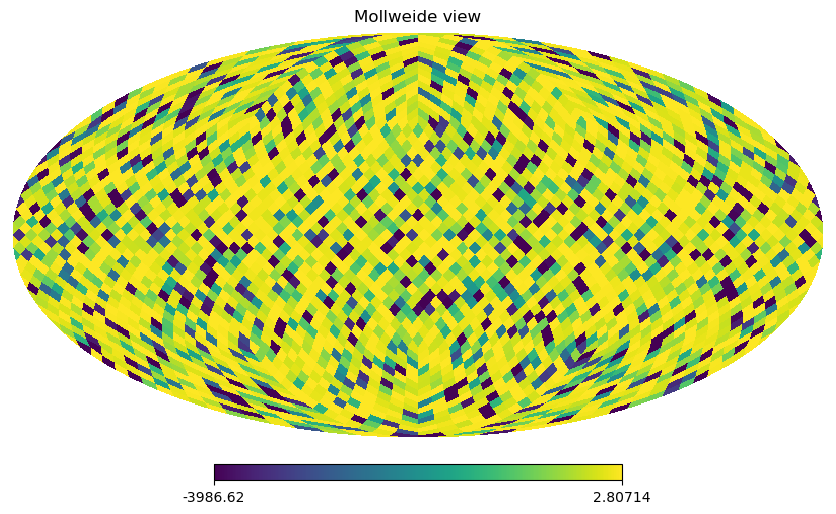

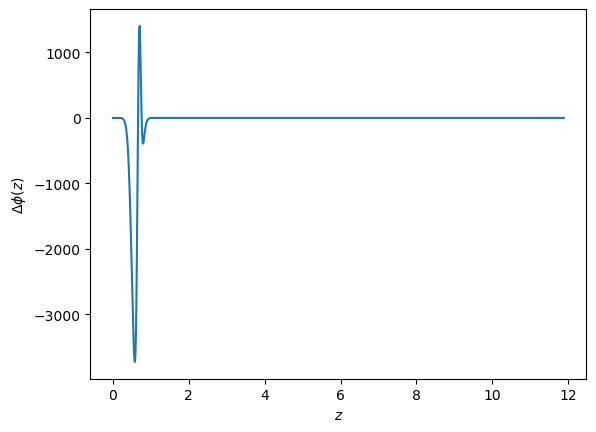

In [31]:
 # Plot a map of an r-slice where we expect significant fluctuations
z_mean_idx = np.where(r_array>Planck18.comoving_distance(z_mean).value)[0][0]
hp.mollview(delta_p_maps[:,z_mean_idx])
plt.show()

# Plot the Delta phi (z) at a random pixel
pix_idx = np.random.randint(0, npix)
plt.plot(z_array[pix_idx,:], delta_p_maps[pix_idx,:])
plt.ylabel(r'$\Delta \phi(z)$')
plt.xlabel(r'$z$')
plt.show()

In [32]:
# Let us up-sample the maps
nside_out = 64 # If running on a laptop, don't go above nside_out=128 (nside_out = 256 already requires 20Gb of memory)

delta_p_maps_upsampled = np.zeros((hp.nside2npix(nside_out), n_samples_of_r))
for i in range(len(r_array)):
    delta_p_maps_upsampled[:,i] = hp.ud_grade(delta_p_maps[:,i], nside_out)
    
delta_p_maps = delta_p_maps_upsampled

In [33]:
# To avoid ringing due to the hard edges on which we seed the anisotropy, we smooth the maps with a Gaussian 
# with sigma equal to 1/2 of the typical width one of the big pixels (characterized by nside, not nside_out)
sigma_gaussian_smoothing = np.sqrt(4*np.pi/npix)/2. * (360*60/(2*np.pi)) # in arcmin

def bl(fwhm_arcmin, lmax):
    """ returns the map-level transfer function for a symmetric Gaussian beam.
         * fwhm_arcmin      = beam full-width-at-half-maximum (fwhm) in arcmin.
         * lmax             = maximum multipole.
    """
    ls = np.arange(0, lmax+1)
    return np.exp( -(fwhm_arcmin * np.pi/180./60.)**2 / (16.*np.log(2.)) * ls*(ls+1.) )

beam = bl(sigma_gaussian_smoothing, 3*nside_out-1)

In [34]:
# Take the spherical harmonic transform of each r slice. Conveniently, we can take complex SHT so array sizes reduce by x2
theta_alms = np.zeros((hp.Alm.getsize(3*nside_out-1), n_samples_of_r), dtype=complex)
for i in range(n_samples_of_r):
    theta_alms[:,i] = hp.map2alm(delta_p_maps[:,i])
    # Smooth the map to reduce ringing due to the hard edges of the big pixels
    theta_alms[:,i] = hp.almxfl(theta_alms[:,i], beam) 

In [35]:
# Next, we will want to take the (l+1/2)th order Hankel transform of each theta_alm
delta_p_lm_of_k = np.zeros((theta_alms.shape[0], n_samples_of_r), dtype=complex) 
lmax = hp.Alm.getlmax(theta_alms.shape[0])
Cl_deltap_of_k1_k2 = np.zeros((lmax+1, n_samples_of_r, n_samples_of_r))
pixwinf = hp.pixwin(nside_out)[0:lmax+1] # Get the pixel window function for the up-sampled pixelization

for i in range(theta_alms.shape[0]):
    if i % 1000 == 0:
        # Print progress
        print('Completed {}%'.format(round(100*i/theta_alms.shape[0]), 3))
    l, m = hp.Alm.getlm(lmax, i) # Get the l corresponding to each value of m
    # Now get the Hankel transforms.
    # Importantly, after discussing with Minas, we use the Stirling approximation to the gamma functions in Eqn 16 
    # of https://jila.colorado.edu/~ajsh/FFTLog/fftlog.pdf, which diverges for mu>342
    k_array, delta_p_lm_of_k[i,:] = hankl.FFTLog(r_array, r_array*theta_alms[i,:], q=0, mu=l+0.5, ext=1, lowring=True, stirling_cutoff=-1)
    delta_p_lm_of_k[i,:] *= 1./k_array # Adapt to the convention in the Hankl code
    # Get angular PS and deconvolve pixel window function for all possible combinations of k1 and k2 
    Cl_deltap_of_k1_k2[l,:,:] += np.outer(delta_p_lm_of_k[i,:], np.conj(delta_p_lm_of_k[i,:])).real/ (2*l+1) / pixwinf[l]**2

# The 2D domain of k's for C_l(k1,k2)
k_mat = np.outer(k_array,k_array)

Completed 0%


/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


Completed 5%
Completed 11%
Completed 16%
Completed 22%
Completed 27%
Completed 32%
Completed 38%
Completed 43%
Completed 49%
Completed 54%
Completed 59%
Completed 65%
Completed 70%
Completed 76%
Completed 81%
Completed 86%
Completed 92%
Completed 97%


### Visualizing $C_l^{\Delta \phi}(k)$

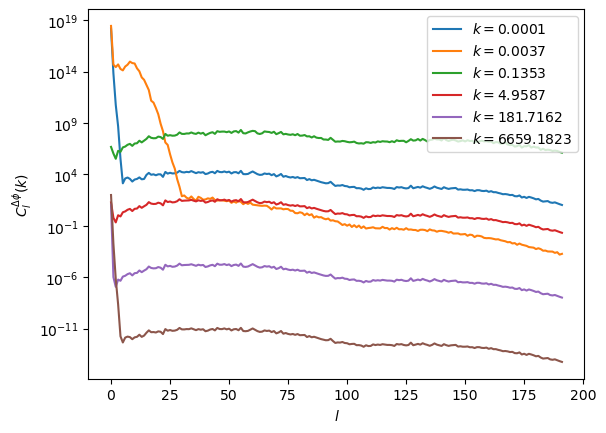

In [36]:
for k_idx, k in zip(np.arange(len(k_array))[::200], k_array[::200]):
    plt.semilogy(Cl_deltap_of_k1_k2[:,k_idx, k_idx], label=r'$k={}$'.format(round(k, 4)))
plt.xlabel(r'$l$')
plt.ylabel(r'$C_l^{\Delta \phi}(k)$')
plt.legend()

There are large oscillations l~350, probably due to the fact that we've had to use Stirling's approximation in FFTLog, but the happen many orders of magnitude below the dominant signal and can probably be ignored. Also, are the bumps at low $l$ physical, or are they numerical artifacts?

(1e-09, 1e+16)

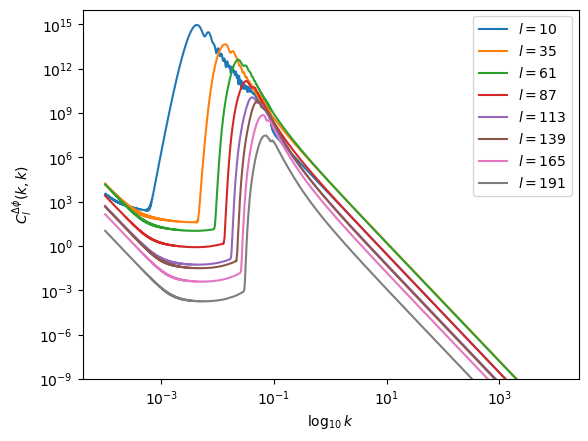

In [45]:
for l_to_plot in np.linspace(10,lmax,8, dtype=int):
    plt.loglog(k_array, np.diagonal(Cl_deltap_of_k1_k2, axis1=1, axis2=2)[l_to_plot,:], label=r'$l={}$'.format(l_to_plot))
plt.xlabel(r'$\mathrm{log}_{10}\,k$')
plt.ylabel(r'$C_l^{\Delta \phi}(k, k)$')
plt.legend()
plt.ylim([1e-9,1e16])

In [38]:
X, Y = np.meshgrid(np.arange(len(k_array)), np.arange(lmax+1))
Z = np.log10(np.diagonal(Cl_deltap_of_k1_k2, axis1=1, axis2=2))

(0.0, 530.0)

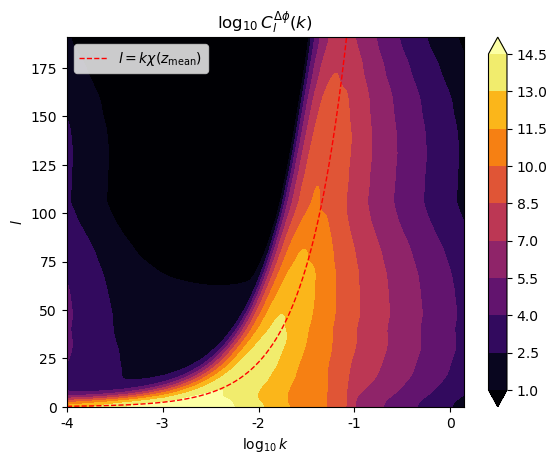

In [48]:
contours = np.arange(1,16,1.5)

# Smooth array with a Gaussian filter for plotting purposes
Z_smoothed = gaussian_filter(Z, sigma=3)
plt.contourf(X, Y, Z_smoothed, levels=contours, cmap='inferno', extend='both')

plt.xlabel(r'$\mathrm{log}_{10}\,k$')
plt.ylabel(r'$l$')

ax = plt.gca()
ax.plot(k_array*Planck18.comoving_distance(z_mean).value, color='r', ls='--', lw=1, label=r'$l=k \chi(z_{\mathrm{mean}})$')
ax.set_ylim([0,lmax])

label_locs = np.arange(int(round(np.log10(np.min(k_array)),0)), int(round(np.log10(np.max(k_array)),0))+1, 1)
ax.set_xticks(np.linspace(0, len(k_array), len(label_locs)))
ax.set_xticklabels(label_locs.astype('str'))
plt.legend()

plt.title(r'$\mathrm{log}_{10} \, C_l^{\Delta \phi}(k)$')
plt.colorbar(location='right')

ax.set_xlim([0,530])

- It's worth investigating the behaviour at low $l$
- How can there be any angular anisotropy at such high $l$ (if suppressed many orders of magnitude relative to the peak signal) if we seeded the perturbations radially on a healpix pixelization characterized by very low nside? 

### Visualizing $C_l^{\Delta \phi}(k_1, k_2)$

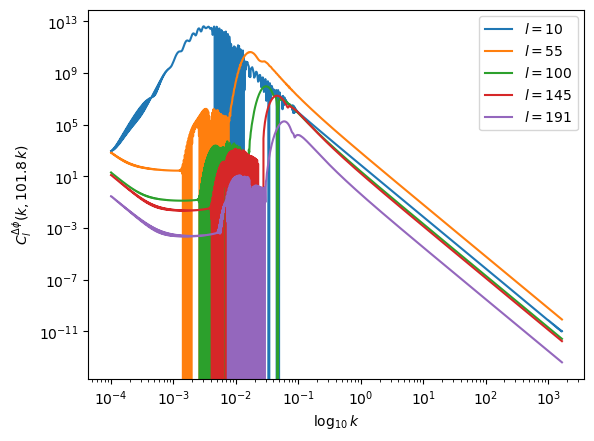

In [49]:
# Let us look into an offset diagonal
offset_idx = 100
offset_k = round((k_array[1]/k_array[0])*offset_idx,1)

for l_to_plot in np.linspace(10,lmax,5, dtype=int):
    plt.loglog(k_array[:-offset_idx], np.diagonal(Cl_deltap_of_k1_k2, axis1=1, axis2=2, offset=offset_idx)[l_to_plot,:], label=r'$l={}$'.format(l_to_plot))
plt.xlabel(r'$\mathrm{log}_{10}\,k$')
plt.ylabel(r'$C_l^{\Delta \phi}(k, $'+str(offset_k)+'$\,k)$')

plt.legend()

Wild oscillations ensue once the shift becomes larger than a few tens, so I don't expect any signal to come from regimes with a larger shift

(0.0, 530.0)

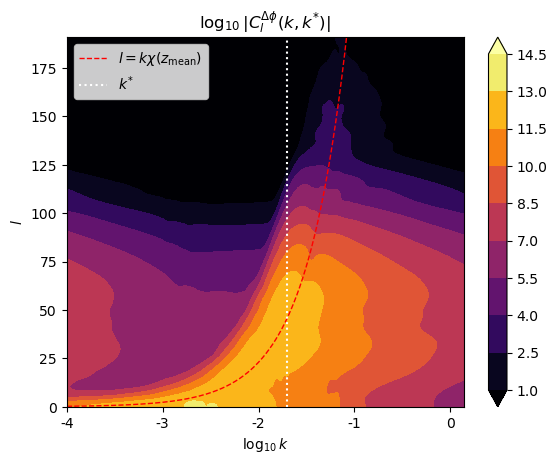

In [50]:
k_idx = np.where(np.log10(k_array)>-1.7)[0][0]

Z_fixed_k = np.log10(np.abs(Cl_deltap_of_k1_k2[:,:,k_idx]))
# Smooth array with a Gaussian filter for plotting purposes
Z_fixed_k_smoothed = gaussian_filter(Z_fixed_k, sigma=3)

plt.contourf(X, Y, Z_fixed_k_smoothed, levels=contours, cmap='inferno', extend='both')

plt.xlabel(r'$\mathrm{log}_{10}\,k$')
plt.ylabel(r'$l$')

ax = plt.gca()
ax.plot(k_array*Planck18.comoving_distance(z_mean).value, color='r', ls='--', lw=1, label=r'$l=k \chi(z_{\mathrm{mean}})$')
ax.set_ylim([0,lmax])

label_locs = np.arange(int(round(np.log10(np.min(k_array)),0)), int(round(np.log10(np.max(k_array)),0))+1, 1)
ax.set_xticks(np.linspace(0, len(k_array), len(label_locs)))
ax.set_xticklabels(label_locs.astype('str'))

plt.title(r'$\mathrm{log}_{10} \, |C_l^{\Delta \phi}(k,k^{*})|$')
plt.colorbar(location='right')

ax.axvline(k_idx, label=r'$k^{*}$', ls=':', color='w')
plt.legend()
ax.set_xlim([0,530])

This suggests that, at a fixed $l$, it might be ok to assume $C_l^{\Delta \phi}(k_1,k_2)\approx \delta^{(D)}(k_1-k_2)C_l^{\Delta \phi}(k_1,k_2)$, especially when $l\gtrapprox50$. NOTE, however, that this might no longer hold if in reality there is some anisotropy to the template, and in fact we don't draw from exactly the same distribution in every pixel.

# Testing FFTLog

/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


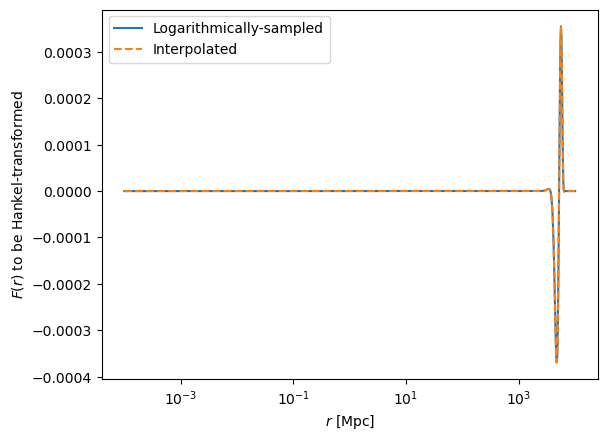

/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.272134e-04
  warnings.warn(
/var/folders/l0/bsqsn6_s01b0hvjnf7bv_wdw0000gn/T/ipykernel_67001/1271661510.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
  p_lm_singlek[i], err[i] = quadrature(integrand, Planck18.comoving_distance(0.01).value,
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.727028e-04
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.221313e-04
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/

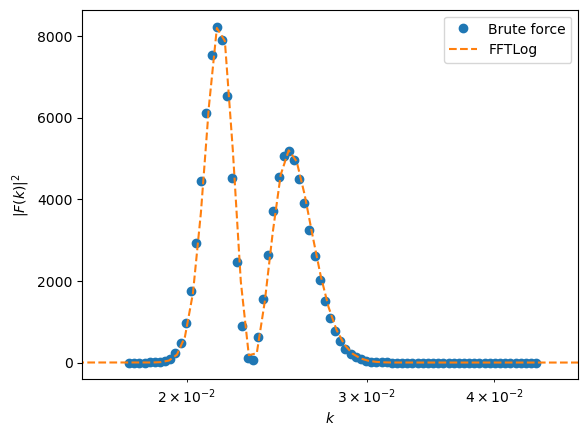

In [15]:
# Choose just one of the m's that we want to Hankel-transform. We will run our test on this one alone
test_idx = 500
# We will need the l corresponding to this m to compute the (l+0.5)th order Hankel transform
test_l, test_m = hp.Alm.getlm(lmax, test_idx) 

# Interpolate the function to be Hankel transformed so we can do it by brute-force
inter_func = interpolate.interp1d(r_array, theta_alms[test_idx,:], bounds_error=True)
plt.semilogx(r_array, theta_alms[test_idx,:], label='Logarithmically-sampled')
plt.semilogx(r_array, inter_func(r_array), ls='--', label='Interpolated')
plt.xlabel(r'$r$ [Mpc]')
plt.ylabel(r'$F(r)$ to be Hankel-transformed')
plt.legend()
plt.show()

# First, integrate using FFTLog
test_k_array, test_delta_p_lm_of_k = hankl.FFTLog(r_array, r_array*theta_alms[test_idx,:], q=0, 
                                                  mu=test_l+0.5, ext=2, lowring=True)
result_fftlog = test_delta_p_lm_of_k*np.conj(test_delta_p_lm_of_k)/test_k_array**2

# Compare to a brute-force numerical integration
def integrand(r, k, test_l):
    # The integrand of the Hankel transform we want
    return inter_func(r) * r * jv(test_l + 0.5, k*r)

# Use the FFTlog calculation to refine the domain overwhich we do brute force
log_kmin_bruteforce = np.log10(test_k_array[np.where(result_fftlog>0.001)[0][0]])
log_kmax_bruteforce = np.log10(test_k_array[np.where(result_fftlog>0.001)[0][-1]])

shortened_test_k_array = np.logspace(log_kmin_bruteforce, log_kmax_bruteforce, 80)
p_lm_singlek = np.zeros_like(shortened_test_k_array)
err = np.zeros_like(shortened_test_k_array)
for i, test_k in enumerate(shortened_test_k_array):
    # At a few values of k, get the Hankel transform by brute force
    p_lm_singlek[i], err[i] = quadrature(integrand, Planck18.comoving_distance(0.01).value, 
                                   Planck18.comoving_distance(10).value, args=(test_k, test_l),
                                         tol=1e-20, , maxiter=500)

plt.semilogx(shortened_test_k_array, p_lm_singlek*np.conj(p_lm_singlek), ls='none', marker='o', label='Brute force')
plt.semilogx(test_k_array, result_fftlog, ls='--', label='FFTLog')
plt.xlabel(r'$k$')
plt.ylabel(r'$|F(k)|^2$')
plt.xlim([10**log_kmin_bruteforce*0.9, 10**log_kmax_bruteforce*1.1])
plt.legend()

# Get galaxy PS

Get the galaxy auto spectrum to second order in the bias expansion for galaxies resembling DES' redmagic sample

In [42]:
#UNIT-redmagic bias parameters from 2101.11014
#         b1,    b2,    bs2,   bnabla2, SN
bvec = [0.786, 0.583, -0.406, -0.512, 1755]

/Users/antonbaleatolizancos/Software/anzu/anzu/emu_funcs.py:226: RuntimeWarning: invalid value encountered in log10
  simoverlpt = np.log10(simoverlpt)


Text(0, 0.5, '$P_{gg}(k)$')

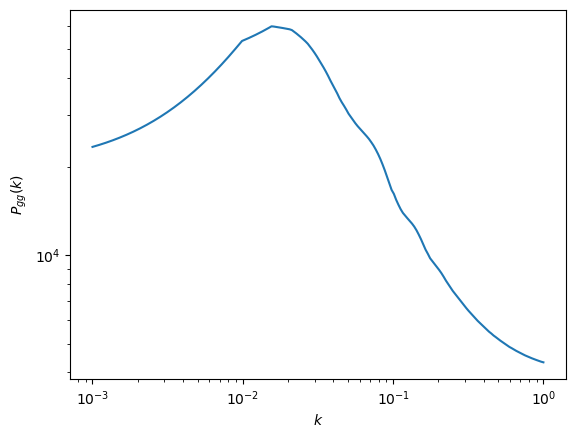

In [43]:
# This cell is copied from Nick Kokron's anzu repository
from anzu.emu_funcs import LPTEmulator
from anzu.utils import _cleft_pk
from anzu.emu_funcs import LPTEmulator
import numpy as np
import pyccl as ccl
from velocileptors.LPT.cleft_fftw import CLEFT
from velocileptors.EPT.cleft_kexpanded_resummed_fftw import RKECLEFT
from scipy.interpolate import interp1d

def compute_velocileptors_spectra(cosmovec, snapscale, use_physical_densities=True, 
                                  use_sigma_8=True, kecleft=True, cleftobj=None):
    '''
    Returns a spline object which computes the cleft component spectra. Computed either in
    "full" CLEFT or in "k-expanded" CLEFT which allows for faster redshift dependence.
    Args:
        cosmovec : array-like
            Vector containing cosmology in the order (ombh2, omch2, w0, ns, sigma8, H0, Neff).
            If self.use_sigma_8 != True, then ln(A_s/10^{-10}) should be provided instead of sigma8.
        snapscale : float
            scale factor
        kecleft: bool
            Bool to check if the calculation is being made with 
    Returns:
        cleft_aem : InterpolatedUnivariateSpline 
            Spline that computes basis spectra as a function of k
    '''

    if use_physical_densities:
        if use_sigma_8:
            cosmo = ccl.Cosmology(Omega_b=cosmovec[0] / (cosmovec[5] / 100)**2,
                                  Omega_c=cosmovec[1] /
                                  (cosmovec[5] / 100)**2,
                                  h=cosmovec[5] / 100, n_s=cosmovec[3],
                                  w0=cosmovec[2], Neff=cosmovec[6],
                                  sigma8=cosmovec[4])
        else:
            cosmo = ccl.Cosmology(Omega_b=cosmovec[0] / (cosmovec[5] / 100)**2,
                                  Omega_c=cosmovec[1] /
                                  (cosmovec[5] / 100)**2,
                                  h=cosmovec[5] / 100, n_s=cosmovec[3],
                                  w0=cosmovec[2], Neff=cosmovec[6],
                                  A_s=np.exp(cosmovec[4]) * 1e-10)
    else:
        if use_sigma_8:
            cosmo = ccl.Cosmology(Omega_b=cosmovec[0],
                                  Omega_c=cosmovec[1] - cosmovec[0],
                                  h=cosmovec[5] / 100, n_s=cosmovec[3],
                                  w0=cosmovec[2], Neff=cosmovec[6],
                                  sigma8=cosmovec[4])
        else:
            cosmo = ccl.Cosmology(Omega_b=cosmovec[0],
                                  Omega_c=cosmovec[1] - cosmovec[0],
                                  h=cosmovec[5] / 100, n_s=cosmovec[3],
                                  w0=cosmovec[2], Neff=cosmovec[6],
                                  A_s=np.exp(cosmovec[4]) * 1e-10)

    k = np.logspace(-3, 1, 1000)

    if kecleft:
        # If using kecleft, check that we're only varying the redshift

        if cleftobj is None:
            # Do the full calculation again, as the cosmology changed.
            pk = ccl.linear_matter_power(
                cosmo, k * cosmo['h'], 1) * (cosmo['h'])**3

            # Function to obtain the no-wiggle spectrum.
            # Not implemented yet, maybe Wallisch maybe B-Splines?
            # pnw = p_nwify(pk)
            # For now just use Stephen's standard savgol implementation.
            cleftobj = RKECLEFT(k, pk)

        # Adjust growth factors
        D = ccl.background.growth_factor(cosmo, snapscale)
        cleftobj.make_ptable(D=D, kmin=k[0], kmax=k[-1], nk=1000)
        cleftpk = cleftobj.pktable.T

    else:
        # Using "full" CLEFT, have to always do calculation from scratch
        pk = ccl.linear_matter_power(
            cosmo, k * cosmo['h'], snapscale) * (cosmo['h'])**3
        cleftobj = CLEFT(k, pk, N=2700, jn=10, cutoff=1)
        cleftobj.make_ptable()

        cleftpk = cleftobj.pktable.T

        # Different cutoff for other spectra, because otherwise different
        # large scale asymptote

        cleftobj = CLEFT(k, pk, N=2700, jn=5, cutoff=10)
        cleftobj.make_ptable()

    cleftpk[3:, :] = cleftobj.pktable.T[3:, :]
    cleftpk[2, :] /= 2
    cleftpk[6, :] /= 0.25
    cleftpk[7, :] /= 2
    cleftpk[8, :] /= 2

    cleftspline = interp1d(cleftpk[0], cleftpk, fill_value='extrapolate')

    return cleftspline, cleftobj

emu = LPTEmulator()

k = np.logspace(-3,0,200)

cosmo_vec = np.atleast_2d([0.023, 0.108, -0.73, 0.98, 0.69,  63.2,  2.95,  1.0])

#compute p_lin to feed to velocileptors
snapscale = cosmo_vec[0,-1]
cosmovec = cosmo_vec[0,:]

lpt_interp, cleftobk = compute_velocileptors_spectra(cosmovec, snapscale,
                                                     use_physical_densities=emu.use_physical_densities,
                                                     use_sigma_8=emu.use_sigma_8, kecleft=False)
lpt_spec = lpt_interp(emu.k)[1:11,:]

emu_spec = emu.predict(k, cosmo_vec, spec_lpt=lpt_spec)

Pkgg = emu.basis_to_full(k, bvec, emu_spec, halomatter=False)

plt.loglog(k, Pkgg)
plt.xlabel(r'$k$')
plt.ylabel(r'$P_{gg}(k)$')

# Calculate biases

#### In the Limber approximation

To DO:
- Check units of anzu output
- Allow Pkgg to vary with redshift? 
- Choose lprime_max more systematically
- Parallelize! (should be rather trivial to do)

Calculate the convolutional bias term (the one that looks like mask convolution)

In [57]:
from sympy.physics.wigner import wigner_3j
from scipy.interpolate import interp1d
from scipy.integrate import quadrature

def integrand_conv_term(r, small_l, big_L, prefactor):
    '''
    Integrand for the convolutional bias term in the Limber approximation.
    Requires globally-defined Pkgg_interp(k) and cldp_interp(k)[l], interpolated in k
    '''
    z_of_r = z_at_value(Planck18.comoving_distance, r* u.Mpc)
    return prefactor * (Planck18.H(z_of_r) / c).value**2 * Pkgg_interp((big_L+0.5)/r) * cldp_interp((small_l+0.5)/r)[small_l] * r**(-6)

# Interpolate the spectra to be integrated over
cldp_interp = interp1d(k_array, np.diagonal(Cl_deltap_of_k1_k2, axis1=1, axis2=2), axis=-1)
Pkgg_interp = interp1d(k, Pkgg, bounds_error=False, fill_value='extrapolate')

lprime_max = 100 #Value of l above which we ignore the anisotropy in C_l^{\Delta \phi}(k)

conv_bias_ells = np.logspace(1.5, 3, 5, dtype=int)
conv_bias = np.zeros_like(conv_bias_ells, dtype=float)

for i, l in enumerate(conv_bias_ells):
    print('Working on l={}; iteration {}/{}'.format(l, i+1, len(conv_bias_ells)))
    for lprime in range(lprime_max):
        for L in np.arange(np.abs(l-lprime), np.abs(l+lprime), 1):
            if (l+lprime+L)%2==0:
                w3 = wigner_3j(l, lprime, L, 0, 0, 0)
                prefactor = 0.5 * float(w3)**2 * (2*lprime+1)**2 * (2*L+1) / (4*np.pi)
                conv_bias[i], error = quadrature(integrand_conv_term, Planck18.comoving_distance(z_min_int).value, 
                                       Planck18.comoving_distance(z_max_int).value, args=(lprime, L, prefactor), maxiter=1000, tol=1e-9)

Working on l=31; iteration 1/5
Working on l=74; iteration 2/5
Working on l=177; iteration 3/5
Working on l=421; iteration 4/5
Working on l=1000; iteration 5/5


Calculate the other, simpler multiplicative term

In [58]:
def integrand_simple_mult_term(r, small_l, phi_normalization):
    '''
    Integrand for the simpler of the two multiplicative bias terms, in the Limber approximation.
    Requires globally-defined Pkgg_interp(k), interpolated in k and assumed to be z-idependent
    '''
    z_of_r = z_at_value(Planck18.comoving_distance, r* u.Mpc)
    return (Planck18.H(z_of_r) / c).value**2 * Pkgg_interp((small_l+0.5)/r) * r**(-5/2.) * phi(r, phi_normalization) * interp_HankTrans_deltapoversqrtk(r) /np.sqrt(np.pi)

# The function that we want to Hankel-transform
deltap00oversqrtk = delta_p_lm_of_k[hp.Alm.getidx(lmax, 0, 0),:]/np.sqrt(k_array)
# The Hankl convention (see https://hankl.readthedocs.io/en/latest/api.html) requires that we first
# multiply the function to be transformed by k_array and then divide the output by r_array
r_array_XFback, HankTrans_deltapoversqrtk = hankl.FFTLog(k_array, k_array*deltap00oversqrtk, 
                                                         q=0, mu=0.5, ext=1, lowring=True, stirling_cutoff=200)
HankTrans_deltapoversqrtk *= 1./r_array
# Interpolate the spectra to be integrated over
interp_HankTrans_deltapoversqrtk = interp1d(r_array, HankTrans_deltapoversqrtk)

mult_bias = np.zeros_like(conv_bias_ells, dtype=float)

for i, l in enumerate(conv_bias_ells):
    print('Working on l={}; iteration {}/{}'.format(l, i+1, len(conv_bias_ells)))
    mult_bias[i], error = quadrature(integrand_simple_mult_term, Planck18.comoving_distance(z_min_int).value, 
                                       Planck18.comoving_distance(z_max_int).value, args=(l, phi_norm), maxiter=500, tol=1e-9)

/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


Working on l=31; iteration 1/5
Working on l=74; iteration 2/5
Working on l=177; iteration 3/5
Working on l=421; iteration 4/5
Working on l=1000; iteration 5/5


Calculate the additive term

In [59]:
def integrand_additive_term(r1, small_l, Clk1k2_interp):
    '''
    Integrand for the additive bias term, in the Limber approximation.
    Requires globally-defined cldp_interp(k1, k2)[l], interpolated in k
    '''
    outer_integral, error = quadrature(integrand_nested_additive_term, Planck18.comoving_distance(z_min_int).value, 
                                       Planck18.comoving_distance(z_max_int).value, args=(r1, small_l, Clk1k2_interp),
                                             maxiter=500, tol=1e-15)
    return outer_integral

def integrand_nested_additive_term(r2, r1, small_l, Clk1k2_interp):
    r1=r1[0]
    r2=r2[0]
    z_of_r1 = z_at_value(Planck18.comoving_distance, r1* u.Mpc)
    z_of_r2 = z_at_value(Planck18.comoving_distance, r2* u.Mpc) 
    prefactor = (Planck18.H(z_of_r1) / c).value * (Planck18.H(z_of_r2) / c).value
    return prefactor * (small_l+0.5) * Clk1k2_interp(np.array((small_l/r1, small_l/r2)))[0] / r1**2 / r2**2

additive_bias_ells = np.logspace(1, np.log10(lmax-5), 10, dtype=int)
additive_bias = np.zeros_like(additive_bias_ells, dtype=float)

for i, l in enumerate(additive_bias_ells):
    print('Working on l={}; iteration {}/{}'.format(l, i+1, len(additive_bias_ells)))
    Clk1k2_interp = interpolate.RegularGridInterpolator((k_array,k_array), Cl_deltap_of_k1_k2[l, :, :],
                                   method='linear', bounds_error=True, fill_value=0)

    additive_bias[i], error = quadrature(integrand_additive_term, Planck18.comoving_distance(z_min_int).value, 
                                       Planck18.comoving_distance(z_max_int).value, args=(l, Clk1k2_interp),
                                         maxiter=1000, tol=1e-9)

Working on l=10; iteration 1/20


/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (500) exceeded. Latest difference = 9.738288e-15
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (500) exceeded. Latest difference = 2.723978e-15
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (500) exceeded. Latest difference = 2.578596e-15
  warnings.warn(


Working on l=11; iteration 2/20


/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (500) exceeded. Latest difference = 5.452948e-15
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (500) exceeded. Latest difference = 1.256436e-15
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (500) exceeded. Latest difference = 1.081874e-15
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (500) exceeded. Latest difference = 1.573761e-15
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning:

Working on l=13; iteration 3/20


/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (500) exceeded. Latest difference = 3.619128e-15
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (500) exceeded. Latest difference = 1.435567e-15
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (500) exceeded. Latest difference = 1.757071e-15
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (500) exceeded. Latest difference = 1.036095e-15
  warnings.warn(


Working on l=15; iteration 4/20
Working on l=18; iteration 5/20
Working on l=21; iteration 6/20
Working on l=25; iteration 7/20
Working on l=29; iteration 8/20
Working on l=34; iteration 9/20
Working on l=39; iteration 10/20
Working on l=46; iteration 11/20
Working on l=54; iteration 12/20
Working on l=63; iteration 13/20
Working on l=73; iteration 14/20
Working on l=86; iteration 15/20
Working on l=100; iteration 16/20
Working on l=117; iteration 17/20
Working on l=136; iteration 18/20
Working on l=159; iteration 19/20
Working on l=186; iteration 20/20


Get the unbiased Clgg for comparison

In [55]:
def integrand_unbiased_auto_term(r, small_l, phi_normalization):
    '''
    Integrand for the unbiased Clgg auto spectrum in the Limber approximation.
    Requires globally-defined Pkgg_interp(k), interpolated in k and assumed to be z-idependent
    '''
    z_of_r = z_at_value(Planck18.comoving_distance, r* u.Mpc) 
    return (Planck18.H(z_of_r) / c).value**2 * Pkgg_interp((small_l+0.5)/r) * r**(-2) * phi(r, phi_normalization)**2

clgg_unbiased = np.zeros_like(conv_bias_ells, dtype=float)

for i, l in enumerate(conv_bias_ells):
    print('Working on l={}; iteration {}/{}'.format(l, i+1, len(conv_bias_ells)))
    clgg_unbiased[i], error = quadrature(integrand_unbiased_auto_term, Planck18.comoving_distance(z_min_int).value, 
                                       Planck18.comoving_distance(z_max_int).value, args=(l, phi_norm), maxiter=1000, tol=1e-9)

Working on l=31; iteration 1/5
Working on l=74; iteration 2/5
Working on l=177; iteration 3/5
Working on l=421; iteration 4/5
Working on l=1000; iteration 5/5


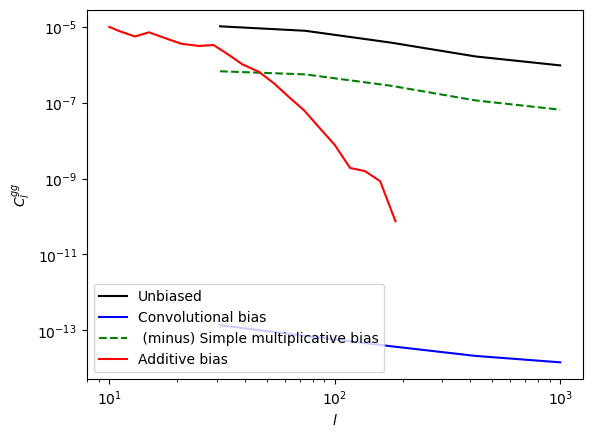

In [63]:
plt.loglog(conv_bias_ells, clgg_unbiased, 'k', label=r'Unbiased')
plt.loglog(conv_bias_ells, conv_bias, 'b', label=r'Convolutional bias')
plt.loglog(conv_bias_ells, -mult_bias, 'g', ls='--', label=r' (minus) Simple multiplicative bias')
plt.loglog(additive_bias_ells, additive_bias, 'r', label=r'Additive bias')

plt.xlabel(r'$l$')
plt.ylabel(r'$C_l^{gg}$')
plt.legend()